Hey!

In [5]:
import anndata
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import scanpy as sc
import sklearn.decomposition #import TruncatedSVD
import scipy 
import sparse, io
import os 
matplotlib.rcParams.update({'font.size': 12})
%config InlineBackend.figure_format = 'retina'

os.chdir('/lunarc/nobackup/projects/regen_immuno/tools/samap/transcriptomes/')
hs_adata=anndata.read_h5ad('/home/nikvaku/snic2022-6-312/LabMemberScratchDir/Nikhilesh/Raw_data/Anno/local.h5ad')

In [6]:
# Set a random seed for reproducibility
np.random.seed(42)

# Identify the unique clusters in the 'free_annotation' column
unique_clusters = hs_adata.obs['free_annotation'].unique()

# Create a DataFrame to store the selected cell indices
selected_indices = []

# Determine the number of cells to select from each cluster
total_cells_to_keep = int(0.3 * len(hs_adata.obs))
cluster_sizes = hs_adata.obs['free_annotation'].value_counts()

# Loop through each cluster and select proportionate cells
for cluster in unique_clusters:
    cluster_indices = hs_adata.obs[hs_adata.obs['free_annotation'] == cluster].index
    n_cells_to_keep = int(cluster_sizes[cluster] / len(hs_adata.obs) * total_cells_to_keep)
    selected_indices.extend(np.random.choice(cluster_indices, n_cells_to_keep, replace=False))

# Create a new AnnData object containing only the selected cells
hs_adata_selected = hs_adata[selected_indices].copy()

# Print information about the selected cells
print(f"Original number of cells: {hs_adata.n_obs}")
print(f"Number of selected cells: {hs_adata_selected.n_obs}")

/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Original number of cells: 264824
Number of selected cells: 79373


The cell selection method provided involves selecting an equal number of cells from each cluster in a single-cell dataset, ensuring balanced representation and preventing dominance by larger clusters during downstream analysis.

In [7]:
hs_res = ('/home/nikvaku/snic2022-6-312/LabMemberScratchDir/Nikhilesh/Inter_data/Tabula_immune.h5ad')
hs_adata_selected.write(hs_res)
# Display variable (gene) names from the selected AnnData object
print("Gene names:")
print(hs_adata_selected.var_names)

Gene names:
Index(['ENSG00000223972', 'ENSG00000227232', 'ENSG00000278267',
       'ENSG00000243485', 'ENSG00000284332', 'ENSG00000237613',
       'ENSG00000268020', 'ENSG00000240361', 'ENSG00000186092',
       'ENSG00000238009',
       ...
       'ENSG00000198886', 'ENSG00000210176', 'ENSG00000210184',
       'ENSG00000210191', 'ENSG00000198786', 'ENSG00000198695',
       'ENSG00000210194', 'ENSG00000198727', 'ENSG00000210195',
       'ENSG00000210196'],
      dtype='object', name='ensemblid', length=58604)


In [8]:
import pandas as pd

dataset=pd.read_csv("/home/nikvaku/snic2022-6-312/LabMemberScratchDir/Nikhilesh/Raw_data/gene&prot.csv")
hs_conversion =dataset.dropna()
print(hs_conversion.head(10))

     Gene stable ID Protein stable ID version
5   ENSG00000198888         ENSP00000354687.2
9   ENSG00000198763         ENSP00000355046.4
15  ENSG00000198804         ENSP00000354499.2
18  ENSG00000198712         ENSP00000354876.1
20  ENSG00000228253         ENSP00000355265.1
21  ENSG00000198899         ENSP00000354632.2
22  ENSG00000198938         ENSP00000354982.2
24  ENSG00000198840         ENSP00000355206.2
26  ENSG00000212907         ENSP00000354728.1
27  ENSG00000198886         ENSP00000354961.2


In [9]:
#Dont have access for some reason
#!wget -O samap_intermediate/hs_to_pw.txt https://lu.box.com/shared/static/fpb5tk1ba1dzs7re1pthlh846bq0ay80.txt
#!wget -O samap_intermediate/pw_to_hs.txt https://lu.box.com/shared/static/sytvvnhkj31tjixn1oidfvttxvjeq1f7.txt

In [10]:
#Importing the reciprocal Blast results
#Humans to pw
hs_pw= pd.read_table("/home/nikvaku/snic2022-6-312/LabMemberScratchDir/Nikhilesh/Raw_data/hs_to_pw.txt")
hs_pw_header = ['ensp', 'pw_pep', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
hs_pw.columns =hs_pw_header
#pw to Humans
pw_hs =pd.read_table("/home/nikvaku/snic2022-6-312/LabMemberScratchDir/Nikhilesh/Raw_data/pw_to_hs.txt")
pw_hs_header = ['pw_pep', 'ensp', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
pw_hs.columns =pw_hs_header

#Creating a mapping dict
mapping_dict = hs_conversion.set_index('Protein stable ID version')['Gene stable ID'].to_dict()

#Mapping the columns of the blast results to the gene ids
hs_pw['ensp'] = hs_pw['ensp'].map(mapping_dict).fillna(hs_pw['ensp'])
pw_hs['ensp'] =pw_hs['ensp'].map(mapping_dict).fillna(hs_pw['ensp'])

In [11]:
import scanpy as sc
spleen_data=sc.read_h5ad('/home/nikvaku/snic2022-6-312/LabMemberScratchDir/Nikhilesh/Raw_data/Anno/spleenR1.h5ad')
spleen_genes = spleen_data.var_names
spleen_genes=pd.DataFrame(spleen_genes)
spleen_genes.columns = ['Gene_Names']
print(spleen_genes)

      Gene_Names
0           POL3
1      gene26597
2      gene26598
3           SPX2
4      gene26599
...          ...
65592     NU5M.1
65593     COX1.1
65594     COX1.2
65595       NU2M
65596  gene65597

[65597 rows x 1 columns]


In [12]:
header=['gene_id','gene_name','Gene_expr']
spleen_id_name = pd.read_table('/home/nikvaku/snic2022-6-312/LabMemberScratchDir/Nikhilesh/Raw_data/features.tsv',names=header)
spleen_id_name          

,gene_id,gene_name,Gene_expr
0,gene26596,POL3,Gene Expression
1,gene26597,gene26597,Gene Expression
2,gene26598,gene26598,Gene Expression
3,gene26595,SPX2,Gene Expression
4,gene26599,gene26599,Gene Expression
...,...,...,...
65592,gene65593,NU5M,Gene Expression
65593,gene65594,COX1,Gene Expression
65594,gene65595,COX1,Gene Expression
65595,gene65596,NU2M,Gene Expression


In [13]:
annot_mapping=pd.read_table('/home/nikvaku/snic2022-6-312/LabMemberScratchDir/Nikhilesh/Raw_data/Anno/annot_mapping.csv')
annot_mapping

,gene_id,transcript_id,sprot_Top_BLASTX_hit,prot_id,EggNM.Preferred_name
0,gene65541,mRNA174710,.,mRNA174710.pep,.
1,gene65590,mRNA174774,.,mRNA174774.pep,.
2,gene65569,mRNA174746,"TSN31_DANRE^TSN31_DANRE^Q:142-588,H:1-149^73.1...",mRNA174746.pep,TSPAN31
3,gene65568,mRNA174743,"YG31B_YEAST^YG31B_YEAST^Q:1973-3145,H:638-1008...",mRNA174743.pep,.
4,gene65568,mRNA174744,"YG31B_YEAST^YG31B_YEAST^Q:1973-3145,H:638-1008...",mRNA174744.pep,.
...,...,...,...,...,...
174777,gene65485,mRNA174600,"E41L3_MOUSE^E41L3_MOUSE^Q:93-1838,H:1-620^75.8...",mRNA174600.pep,EPB41L3
174778,gene65485,mRNA174599,"E41L3_MOUSE^E41L3_MOUSE^Q:93-1841,H:1-620^75.7...",mRNA174599.pep,EPB41L3
174779,gene65485,mRNA174598,"E41L3_MOUSE^E41L3_MOUSE^Q:229-1962,H:6-620^75....",mRNA174598.pep,EPB41L3
174780,gene65485,mRNA174602,"E41L3_MOUSE^E41L3_MOUSE^Q:93-1931,H:1-620^80.7...",mRNA174602.pep,EPB41L3


In [40]:
mapping_dict_anno =annot_mapping.set_index('prot_id')['gene_id'].to_dict()
hs_pw['pw_pep'] = hs_pw['pw_pep'].map(mapping_dict_anno).fillna(hs_pw['pw_pep'])
hs_pw
mapping_dict_anno

{'mRNA174710.pep': 'gene65541',
 'mRNA174774.pep': 'gene65590',
 'mRNA174746.pep': 'gene65569',
 'mRNA174743.pep': 'gene65568',
 'mRNA174744.pep': 'gene65568',
 'mRNA174745.pep': 'gene65568',
 'mRNA174742.pep': 'gene65568',
 'mRNA174750.pep': 'gene65570',
 'mRNA174749.pep': 'gene65570',
 'mRNA174748.pep': 'gene65570',
 'mRNA174747.pep': 'gene65570',
 'mRNA114463.pep': 'gene43048',
 'mRNA114460.pep': 'gene43048',
 'mRNA114462.pep': 'gene43048',
 'mRNA114461.pep': 'gene43048',
 'mRNA108328.pep': 'gene40732',
 'mRNA108327.pep': 'gene40732',
 'mRNA108324.pep': 'gene40732',
 'mRNA108325.pep': 'gene40732',
 'mRNA108326.pep': 'gene40732',
 'mRNA103662.pep': 'gene39011',
 'mRNA108960.pep': 'gene40992',
 'mRNA105967.pep': 'gene39884',
 'mRNA108644.pep': 'gene40862',
 'mRNA108643.pep': 'gene40862',
 'mRNA106289.pep': 'gene40015',
 'mRNA113420.pep': 'gene42707',
 'mRNA113421.pep': 'gene42707',
 'mRNA108432.pep': 'gene40776',
 'mRNA103242.pep': 'gene38828',
 'mRNA103243.pep': 'gene38828',
 'mRNA10

In [15]:
pw_hs['pw_pep']=pw_hs['pw_pep'].map(mapping_dict_anno).fillna(pw_hs['pw_pep'])
pw_hs

,pw_pep,ensp,3,4,5,6,7,8,9,10,11,12
0,gene65569,ENSG00000135452,79.808,104,21,0,1,104,1,104,2.030000e-53,166.0
1,gene65569,ENSG00000135452,79.808,104,21,0,1,104,1,104,3.360000e-53,166.0
2,gene65569,ENSG00000106537,59.286,140,55,2,1,139,1,139,4.180000e-42,140.0
3,gene65569,ENSG00000135452,86.154,65,9,0,1,65,1,65,2.080000e-30,107.0
4,gene65569,ENSG00000135452,51.389,72,32,1,79,150,1,69,4.920000e-19,77.4
...,...,...,...,...,...,...,...,...,...,...,...,...
5239034,gene65485,ENSG00000139926,21.687,249,161,8,140,354,41,289,4.210000e-07,55.1
5239035,gene65485,ENSG00000153303,22.553,235,157,7,137,347,8,241,4.310000e-07,55.1
5239036,gene65485,ENSG00000007944,31.915,94,61,2,301,393,4,95,5.820000e-07,53.5
5239037,gene65485,ENSG00000171914,25.170,147,106,2,168,310,174,320,9.790000e-07,54.7


In [16]:
spleen_genes_ids=spleen_id_name['gene_id']
spleen_genes_ids

0        gene26596
1        gene26597
2        gene26598
3        gene26595
4        gene26599
           ...    
65592    gene65593
65593    gene65594
65594    gene65595
65595    gene65596
65596    gene65597
Name: gene_id, Length: 65597, dtype: object

Starting the process from the SAMap vignett

In [17]:
from samap.mapping import SAMAP
from samap.analysis import (get_mapping_scores, GenePairFinder,
                            sankey_plot, chord_plot, CellTypeTriangles,
                            ParalogSubstitutions, FunctionalEnrichment,
                            convert_eggnog_to_homologs, GeneTriangles)
from samalg import SAM
import pandas as pd

In [18]:
org1 ='/home/nikvaku/snic2022-6-312/LabMemberScratchDir/Nikhilesh/Raw_data/Anno/Pw_spleenR1.h5ad'
org2 ='/home/nikvaku/snic2022-6-312/LabMemberScratchDir/Nikhilesh/Raw_data/Anno/Tabula_immune.h5ad'
filenames = {'pw':org1,'hs':org2}

sm = SAMAP(
        filenames,
        f_maps = 'maps/',
        save_processed=True, #if False, do not save the processed results to `*_pr.h5ad`
        keys = {'pw':'seurat_clusters','hs':'free_annotation'},
   )

Processing data pw from:
/home/nikvaku/snic2022-6-312/LabMemberScratchDir/Nikhilesh/Raw_data/Anno/Pw_spleenR1.h5ad
RUNNING SAM
Iteration: 0, Convergence: 1.0
Iteration: 1, Convergence: 0.9189743901969982
Iteration: 2, Convergence: 0.019601613299668946
Computing the UMAP embedding...
Elapsed time: 72.56070375442505 seconds
Not updating the manifold...
Processing data hs from:
/home/nikvaku/snic2022-6-312/LabMemberScratchDir/Nikhilesh/Raw_data/Anno/Tabula_immune.h5ad
RUNNING SAM
Iteration: 0, Convergence: 1.0
Iteration: 1, Convergence: 0.9155200781345522
Iteration: 2, Convergence: 0.012371694142432192
Computing the UMAP embedding...
Elapsed time: 217.37453150749207 seconds
Not updating the manifold...
24468 `pw` gene symbols match between the datasets and the BLAST graph.
18696 `hs` gene symbols match between the datasets and the BLAST graph.


In [19]:
sm.run()
samap = sm.samap

Prepping datasets for translation.


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Translating feature spaces pairwise.
Projecting data into joint latent space. 90.68239688873291
Correcting data with means. 74.05767941474915
Expanding neighbourhoods of species pw...
Expanding neighbourhoods of species hs...
Indegree coarsening
0/5 (0, 98432)
1/5 (20000, 98432)
2/5 (40000, 98432)
3/5 (60000, 98432)
4/5 (80000, 98432)
Rescaling edge weights by expression correlations.
Concatenating SAM objects...
Iteration 1 complete.
Alignment scores:
          hs        pw
hs  0.000000  0.502831
pw  0.649972  0.000000
Calculating gene-gene correlations in the homology graph...


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Prepping datasets for translation.


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Translating feature spaces pairwise.
Projecting data into joint latent space. 56.636977434158325
Correcting data with means. 83.44268155097961
Expanding neighbourhoods of species pw...
Expanding neighbourhoods of species hs...
Indegree coarsening
0/5 (0, 98432)
1/5 (20000, 98432)
2/5 (40000, 98432)
3/5 (60000, 98432)
4/5 (80000, 98432)
Rescaling edge weights by expression correlations.
Concatenating SAM objects...
Iteration 2 complete.
Alignment scores:
          hs        pw
hs  0.000000  0.564554
pw  0.731011  0.000000
Calculating gene-gene correlations in the homology graph...


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Prepping datasets for translation.


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Translating feature spaces pairwise.
Projecting data into joint latent space. 56.6460599899292
Correcting data with means. 73.09908294677734
Expanding neighbourhoods of species pw...
Expanding neighbourhoods of species hs...
Indegree coarsening
0/5 (0, 98432)
1/5 (20000, 98432)
2/5 (40000, 98432)
3/5 (60000, 98432)
4/5 (80000, 98432)
Rescaling edge weights by expression correlations.
Concatenating SAM objects...
Iteration 3 complete.
Alignment scores:
          hs        pw
hs  0.000000  0.571832
pw  0.736431  0.000000
Running UMAP on the stitched manifolds.
Elapsed time: 19.33226795196533 minutes.


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [20]:
from samap.utils import save_samap
save_samap(sm, '/home/nikvaku/snic2022-6-312/LabMemberScratchDir/Nikhilesh/Inter_data/pw_hs_spl_SAM.pkl')

#To load in SAMAP directly
#import pickle
#with open('/home/nikvaku/snic2022-6-312/LabMemberScratchDir/Nikhilesh/Inter_data/pw_hs_spl_SAM.pkl', 'rb') as f:
#    sm = pickle.load(f)
#samap =sm.samap





In [21]:
samap.adata.obs
keys = {'pw':'seurat_clusters','hs':'tissue'}
D,MappingTable = get_mapping_scores(sm,keys,n_top = 0)
D.head()
MappingTable.head()

,pw_0,pw_1,pw_10,pw_11,pw_12,pw_13,pw_14,pw_15,pw_16,pw_17,...,hs_skin of chest,hs_small intestine,hs_spleen,hs_subcutaneous adipose tissue,hs_sublingual gland,hs_thymus,hs_tongue,hs_trachea,hs_uterus,hs_vasculature
pw_0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.201666,0.482384,0.115849,0.249441,0.132885,0.130985,0.183079,0.191340,0.197026,0.133745
pw_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.006171,0.021024,0.122493,0.004656,0.003590,0.113692,0.000000,0.024548,0.005028,0.007055
pw_10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.002117,0.008458,0.056906,0.006082,0.002214,0.049926,0.083638,0.001530,0.001845,0.006041
pw_11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.032085,0.003588,0.010342,0.000644,0.000000,0.006549,0.000000,0.015019,0.000000,0.025236
pw_12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.095557,0.000261,0.000037,0.000094,0.000000,0.002615,0.000000,0.001554


Plotting the Mapped clusters

In [32]:
import holoviews


chord_plot(MappingTable, align_thr=0.05)

/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/holoviews/core/util.py:1175: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  return pd.unique(values)
/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/holoviews/core/util.py:1175: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  return pd.unique(values)
/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/holoviews/core/util.py:1175: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  return pd.unique(values)
/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/holoviews/core/util.py:1175: FutureWarning: unique with argument that is not not a Se

:Chord   [source,target]   (value,edge_grp)

<Axes: >

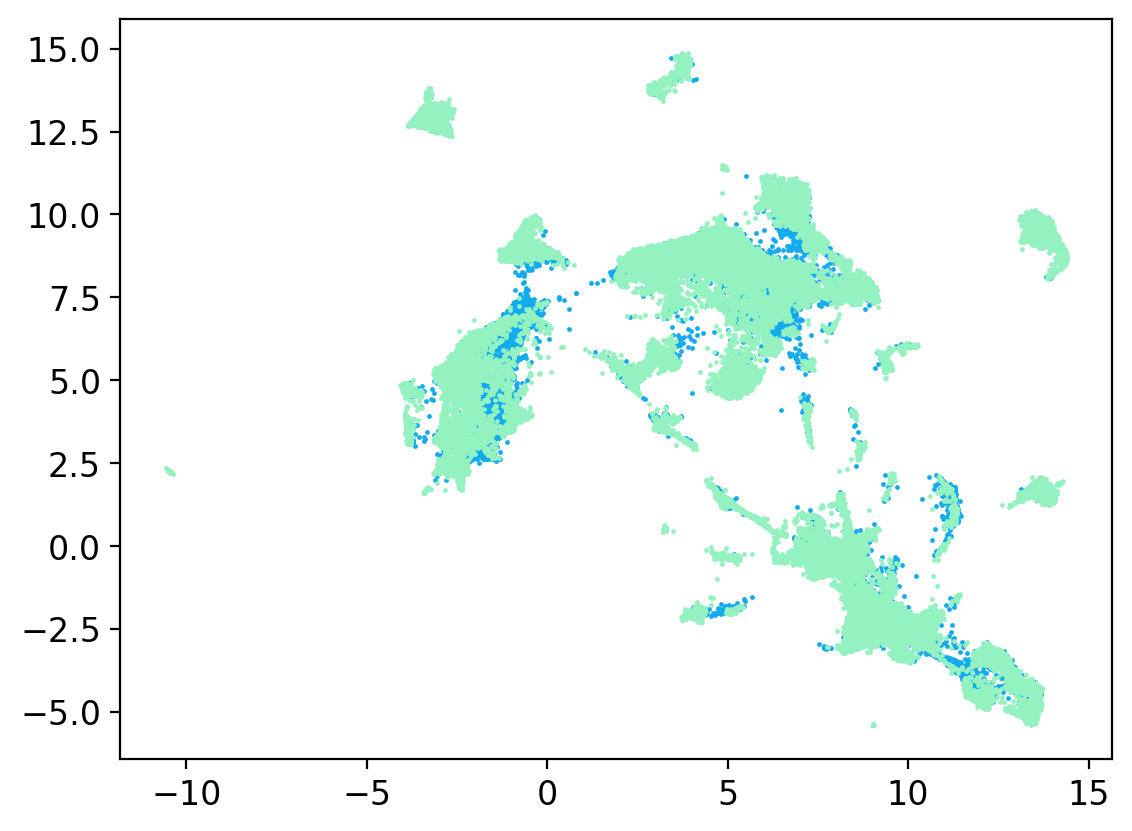

In [33]:
sm.scatter()

In [35]:
gpf = GenePairFinder(sm,keys=keys)

gene_pairs = gpf.find_all(align_thr=0.2)

/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Finding cluster-specific markers in pw:seurat_clusters.
Finding cluster-specific markers in hs:tissue.
Calculating gene pairs for the mapping: hs;adipose tissue to pw;0


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Calculating gene pairs for the mapping: hs;anterior part of tongue to pw;0


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Calculating gene pairs for the mapping: hs;aorta to pw;5


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Calculating gene pairs for the mapping: hs;bladder organ to pw;0


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Calculating gene pairs for the mapping: hs;blood to pw;12


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Calculating gene pairs for the mapping: hs;blood to pw;15


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Calculating gene pairs for the mapping: hs;blood to pw;18


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Calculating gene pairs for the mapping: hs;blood to pw;19


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Calculating gene pairs for the mapping: hs;blood to pw;6


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Calculating gene pairs for the mapping: hs;blood to pw;7


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Calculating gene pairs for the mapping: hs;blood to pw;8


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Calculating gene pairs for the mapping: hs;blood to pw;9


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Calculating gene pairs for the mapping: hs;bone marrow to pw;13


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Calculating gene pairs for the mapping: hs;bone marrow to pw;8


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Calculating gene pairs for the mapping: hs;cardiac atrium to pw;5


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Calculating gene pairs for the mapping: hs;cardiac ventricle to pw;5


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Calculating gene pairs for the mapping: hs;coronary artery to pw;5


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Calculating gene pairs for the mapping: hs;endometrium to pw;0


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Calculating gene pairs for the mapping: hs;exocrine pancreas to pw;0


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Calculating gene pairs for the mapping: hs;inguinal lymph node to pw;1


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Calculating gene pairs for the mapping: hs;kidney to pw;3


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Calculating gene pairs for the mapping: hs;lacrimal gland to pw;13


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Calculating gene pairs for the mapping: hs;large intestine to pw;0


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Calculating gene pairs for the mapping: hs;liver to pw;0


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Calculating gene pairs for the mapping: hs;liver to pw;5


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Calculating gene pairs for the mapping: hs;lung to pw;0


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Calculating gene pairs for the mapping: hs;lung to pw;16


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Calculating gene pairs for the mapping: hs;lung to pw;5


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Calculating gene pairs for the mapping: hs;lymph node to pw;1


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Calculating gene pairs for the mapping: hs;lymph node to pw;11


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Calculating gene pairs for the mapping: hs;lymph node to pw;2


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Calculating gene pairs for the mapping: hs;lymph node to pw;20


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Calculating gene pairs for the mapping: hs;lymph node to pw;4


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Calculating gene pairs for the mapping: hs;mammary gland to pw;0


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Calculating gene pairs for the mapping: hs;muscle of abdomen to pw;0


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Calculating gene pairs for the mapping: hs;muscle of pelvic diaphragm to pw;5


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Calculating gene pairs for the mapping: hs;muscle tissue to pw;0


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Calculating gene pairs for the mapping: hs;muscle tissue to pw;13


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Calculating gene pairs for the mapping: hs;myometrium to pw;0


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Calculating gene pairs for the mapping: hs;posterior part of tongue to pw;0


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Calculating gene pairs for the mapping: hs;prostate gland to pw;0


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Calculating gene pairs for the mapping: hs;rectus abdominis muscle to pw;0


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Calculating gene pairs for the mapping: hs;skin of abdomen to pw;0


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Calculating gene pairs for the mapping: hs;skin of body to pw;0


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Calculating gene pairs for the mapping: hs;skin of chest to pw;0


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Calculating gene pairs for the mapping: hs;small intestine to pw;0


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Calculating gene pairs for the mapping: hs;subcutaneous adipose tissue to pw;0


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Calculating gene pairs for the mapping: hs;vasculature to pw;5


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [41]:
gene_pairs.head()


,hs_adipose tissue;pw_0,hs_adipose tissue;pw_0_pval1,hs_adipose tissue;pw_0_pval2,hs_anterior part of tongue;pw_0,hs_anterior part of tongue;pw_0_pval1,hs_anterior part of tongue;pw_0_pval2,hs_aorta;pw_5,hs_aorta;pw_5_pval1,hs_aorta;pw_5_pval2,hs_bladder organ;pw_0,...,hs_skin of chest;pw_0_pval2,hs_small intestine;pw_0,hs_small intestine;pw_0_pval1,hs_small intestine;pw_0_pval2,hs_subcutaneous adipose tissue;pw_0,hs_subcutaneous adipose tissue;pw_0_pval1,hs_subcutaneous adipose tissue;pw_0_pval2,hs_vasculature;pw_5,hs_vasculature;pw_5_pval1,hs_vasculature;pw_5_pval2
0,hs_ENSG00000133083;pw_gene15882,0.0,0.0,hs_ENSG00000170477;pw_gene34445,0.0,0.0,hs_ENSG00000159189;pw_gene47418,0.0,0.0,hs_ENSG00000120694;pw_gene53400,...,0.0,hs_ENSG00000173585;pw_gene44286,0.0,0.0,hs_ENSG00000211445;pw_gene64239,0.0,0.0,hs_ENSG00000158270;pw_gene3305,0.0,0.0
1,hs_ENSG00000133083;pw_gene10154,0.0,0.0,hs_ENSG00000170477;pw_gene34444,0.0,0.0,hs_ENSG00000159189;pw_gene47742,0.0,0.0,hs_ENSG00000120694;pw_gene27052,...,0.0,hs_ENSG00000168685;pw_gene16807,0.0,0.0,hs_ENSG00000170323;pw_gene40032,0.0,0.0,hs_ENSG00000088827;pw_gene11289,0.0,0.0
2,hs_ENSG00000211445;pw_gene64239,0.0,0.0,hs_ENSG00000171401;pw_gene34445,0.0,0.0,hs_ENSG00000173372;pw_gene47418,0.0,0.0,hs_ENSG00000135047;pw_gene37485,...,0.001355,hs_ENSG00000173585;pw_gene9959,0.0,0.0,hs_ENSG00000120694;pw_gene53133,0.0,0.0,hs_ENSG00000260314;pw_gene3305,0.0,0.0
3,hs_ENSG00000196569;pw_gene11047,0.0,0.0,hs_ENSG00000171401;pw_gene34444,0.0,0.0,hs_ENSG00000159189;pw_gene47419,0.0,0.0,hs_ENSG00000120694;pw_gene53133,...,0.006353,hs_ENSG00000173585;pw_gene58717,0.0,0.000007,hs_ENSG00000120694;pw_gene27052,0.0,0.0,hs_ENSG00000153208;pw_gene53742,0.0,0.0
4,hs_ENSG00000134853;pw_gene10115,0.0,0.0,hs_ENSG00000205420;pw_gene34445,0.0,0.0,hs_ENSG00000153208;pw_gene53742,0.0,0.0,hs_ENSG00000204389;pw_gene53400,...,0.0,hs_ENSG00000173585;pw_gene26241,0.0,0.000001,hs_ENSG00000204389;pw_gene27052,0.0,0.0,hs_ENSG00000090659;pw_gene3305,0.0,0.0


In [42]:
Enrichment=FunctionalEnrichment(sm,EGGs,col_key='KOG',keys=keys,align_thr=0.01)

NameError: name 'EGGs' is not defined

In [46]:
pw_egg_1 = pd.read_table('/home/nikvaku/snic2022-6-312/LabMemberScratchDir/Nikhilesh/Raw_data/pw_eggnog_part1.tsv')

In [1]:
pw_egg_1['eggNOG_OGs']

NameError: name 'pw_egg_1' is not defined